# PyTorch based CNN and ViT Hybrid for image classification

### 1. Import required libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import random
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from datetime import datetime

def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')



import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

### 2. Load CNN model

In [2]:
pytorch_state_dict_name = "cnn_pytorch_state_dict.pth"
pytorch_state_dict_path = os.path.join(os.getcwd(), "..", "models", pytorch_state_dict_name)

### 3. Defining pre-trained CNN

In [12]:
class ConvNet(nn.Module):
    ''' 
    Class to define the architecture same as the imported pre-trained CNN model
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024)
        )

    def forward_features(self, x):
        return self.features(x)      # (B,1024,H,W)


### 4. Vision Transformers

### 4.1 Patch embedding
 The **PatchEmbed** class implements the **interface** between the CNN feature extractor and the Vision Transformer, converting spatial feature maps into a sequence of tokens suitable for self-attention processing.

 The transformation process involves three key steps:
1. **Channel projection**: `nn.Conv2d(in_ch, embed_dim, kernel_size=1)` reduces or expands the channel dimension from 1024 to the preferred embedding size
2. **Spatial flattening**: `.flatten(2)` collapses the height and width dimensions (H×W) into a single sequence dimension
3. **Tensor reshaping**: `.transpose(1,2)` reorders dimensions from (B, D, L) to (B, L, D) where L=H×W represents the sequence length

**Integration with hybrid architecture**

In the context of the hybrid model, this patch embedding serves as the **bridge** between local CNN features and global transformer processing. Since the CNN has already extracted meaningful local patterns, the patch embedding focuses on format conversion rather than feature extraction. This design is more **efficient** than traditional ViT patch embedding since the CNN has already performed the heavy lifting of feature extraction from raw pixels.

The **output tensor** (B, L, D) represents a batch of sequences where each sequence contains L tokens (corresponding to spatial locations in the feature map) with D-dimensional embeddings ready for transformer processing.

In [13]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel=1024, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1)  # 1×1 conv
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B,L,D)
        return x

### 4.2 Multi-head self-attention (MHSA) module

The **MHSA** class implements the self-attention mechanism that enables the Vision Transformer to model long-range dependencies and global context across all spatial locations in the feature map.

The implementation follows the scaled dot-product attention formula: **Attention(Q,K,V) = softmax(QK^T/√d)V**, where Q, K, and V represent query, key, and value matrices, respectively. The scaling factor 1/sqrt(d) prevents the dot products from becoming too large, which would push the softmax function into regions with extremely small gradients.

The multi-head mechanism splits the embedding dimension across multiple attention heads, allowing the model to attend to different types of relationships simultaneously. 

### Key implementation details:

- **Unified QKV projection**: A single linear layer `nn.Linear(dim, dim*3)` generates Q, K, and V matrices efficiently, reducing memory overhead compared to separate projections
- **Head reshaping**: The tensor is reshaped from (B, N, D) to (B, heads, N, d) where d = D/heads, enabling parallel processing across heads
- **Attention computation**: Matrix multiplication `torch.matmul(q, k.transpose(-2, -1))` computes attention scores, followed by scaling and softmax normalization
- **Dropout regularization**: Two dropout layers prevent overfitting - one on attention weights and one on the final output


Unlike CNNs, which have limited receptive fields, self-attention allows every token to interact directly with every other token in a single operation. This enables the model to **capture long-range spatial dependencies** that might be missed by purely convolutional approaches. 

#### In the hybrid architecture, this global modeling complements the local feature extraction performed by the CNN backbone.

The attention weights provide interpretability, showing which spatial locations the model focuses on when making predictions. This component is valuable for both performance and explainability.


In [14]:
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2)  # (B, heads, N, d)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

### 4.3 Transformer block
This code defines a building block used in modern deep learning models, especially in Vision Transformers. The class is called TransformerBlock, and it is responsible for helping the model “pay attention” to the most important parts of its input and improve the final predictions.

Let’s break down what happens inside:

**Layer normalization (nn.LayerNorm):** This helps stabilize and speed up training by normalizing each row of the input data, which is useful before applying attention or a neural network layer.

**Attention layer (MHSA):** This is the “Multi-Head Self Attention” block. It enables the model to look at all positions in the sequence (or image patches) at once, figuring out which ones are most important for each output. It’s like giving the model the power to focus on the key parts of an image or sentence.

**MLP (nn.Sequential):** This is a **Multi-Layer Perceptron** or a mini neural network, made up of linear (fully connected) layers, a special activation (GELU), and dropout for regularization. This MLP has:
- One linear layer that expands the input dimension by mlp_ratio (for example, 4× wider).
- A GELU activation function (a nonlinear operation, similar to ReLU).
- Dropout for regularization (helps prevent overfitting).
- Another linear layer that shrinks the data back to the original dimension.
- Another dropout layer.
Here, MLP is designed to help the model learn better representations by combining and transforming the information after the attention step.

**Skip/Residual connections (x + ...):** These connections support effective and stable training for deep neural networks by keeping pathways open for both forward information flow and backward gradient flow, making deep architectures such as transformers possible and practical. In transformers, skip connections are placed around both the attention and feedforward (MLP) sub-layers in each block. This stabilizes training of these very deep, stackable models, improves convergence speed, and lets them scale to larger datasets and more complex tasks.

In summary, this block helps models understand relationships in their input data, making them more powerful for tasks such as image and language understanding!


In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = nn.Sequential(
                                    nn.Linear(dim, int(dim * mlp_ratio)),
                                    nn.GELU(), nn.Dropout(dropout),
                                    nn.Linear(int(dim * mlp_ratio), dim),
                                    nn.Dropout(dropout))
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

### 4.4  Vision Transformer (ViT) model
The **ViT** class represents the complete Vision Transformer implementation, including patch embedding, positional encoding, transformer blocks, and a classification head for global context modeling.

In [16]:
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=9,
                 embed_dim=768, depth=6, heads=8,
                 mlp_ratio=4., dropout=0.1, max_tokens=50):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)           # 1×1 conv
        self.cls   = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos   = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                          # x: (B,C,H,W)
        x = self.patch(x)                          # (B,L,D)
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)           # (B,1,D)
        x = torch.cat((cls, x), 1)                 # (B,L+1,D)
        x = x + self.pos[:, :L + 1]                # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])       # CLS token

### 5. CNN-ViT hybrid model
The forward pass implements a **two-stage forward pass pipeline**:
1. **Local feature extraction**: `self.cnn.forward_features(x)` processes the input image through the CNN backbone, extracting hierarchical local features and reducing spatial resolution while increasing semantic depth.
2. **Global context modeling**: `self.vit(features)` takes the CNN feature map and processes it through the Vision Transformer for global reasoning and classification.

In [17]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=768, depth=6, heads=8):
        super().__init__()
        self.cnn = ConvNet(num_classes)            # load weights later
        self.vit = ViT(num_classes=num_classes,
                       embed_dim=embed_dim,
                       depth=depth,
                       heads=heads)
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

### 6. Model training and evaluation functions

In [18]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training  ")):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

### 7.  Data preparation and loading 

In [19]:
dataset_path = r"C:\MscR\Philippines(GEDI_Resampled)\_combined"

img_size = 64
batch_size = 32
lr = 0.001
num_cls  = 9


train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.RandomRotation(40),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

val_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                       )

### 8. Model initialization and training

In [20]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")


epochs     = 30
attn_heads = 6
depth      = 3
embed_dim  = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = os.path.join(os.getcwd(), "..", "models" , "pytorch_vit_model_state_dict.pth")

model     = CNN_ViT_Hybrid(num_classes=num_cls,
                            heads=attn_heads,
                            depth=depth,
                            embed_dim=embed_dim
                           ).to(device)


# ------------------------------------------------------------------ #
# loading pre-trained CNN weights
model.cnn.load_state_dict(torch.load(pytorch_state_dict_path), strict=False)
# ------------------------------------------------------------------ #


criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=lr)


best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = []

training_time = []
for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch:02d}/{epochs:02d} started at {present_time()} (UTC)")
    tr_loss,tr_acc = train(model, train_loader, optimizer, criterion, device)
    te_loss,te_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)
    
    # Save the best model
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


Training the model on cuda
epochs:30 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768

Epoch 01/30 started at 20251028_175852 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [03:36<00:00, 18.67it/s]


Epoch 01 | train loss 1.8899 acc 0.2749 | val loss 1.8379 acc 0.2885 | in  1722.38s
Current loss (1.8379) lower than previous best loss (inf), Saving current model state

Epoch 02/30 started at 20251028_182735 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [03:31<00:00, 19.15it/s]


Epoch 02 | train loss 1.8410 acc 0.2883 | val loss 1.8411 acc 0.2887 | in  1680.39s

Epoch 03/30 started at 20251028_185535 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [03:29<00:00, 19.25it/s]


Epoch 03 | train loss 1.8226 acc 0.2941 | val loss 1.8119 acc 0.2948 | in  1662.73s
Current loss (1.8119) lower than previous best loss (1.8379), Saving current model state

Epoch 04/30 started at 20251028_192318 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [03:31<00:00, 19.13it/s]


Epoch 04 | train loss 1.8215 acc 0.2934 | val loss 1.8008 acc 0.2977 | in  1677.11s
Current loss (1.8008) lower than previous best loss (1.8119), Saving current model state

Epoch 05/30 started at 20251028_195115 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [03:30<00:00, 19.18it/s]


Epoch 05 | train loss 1.8056 acc 0.2971 | val loss 1.7919 acc 0.2992 | in  1660.32s
Current loss (1.7919) lower than previous best loss (1.8008), Saving current model state

Epoch 06/30 started at 20251028_201856 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [03:37<00:00, 18.63it/s]


Epoch 06 | train loss 1.8033 acc 0.2977 | val loss 1.7926 acc 0.3004 | in  1674.64s

Epoch 07/30 started at 20251028_204650 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [03:38<00:00, 18.51it/s]


Epoch 07 | train loss 1.8015 acc 0.2986 | val loss 1.7959 acc 0.2993 | in  1674.93s

Epoch 08/30 started at 20251028_211445 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:55<00:00, 23.08it/s]


Epoch 08 | train loss 1.7878 acc 0.3013 | val loss 1.7725 acc 0.3069 | in  1573.44s
Current loss (1.7725) lower than previous best loss (1.7919), Saving current model state

Epoch 09/30 started at 20251028_214059 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:16<00:00, 29.69it/s]


Epoch 09 | train loss 1.7974 acc 0.2992 | val loss 1.7818 acc 0.3037 | in  1297.07s

Epoch 10/30 started at 20251028_220236 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:19<00:00, 28.99it/s]


Epoch 10 | train loss 1.7866 acc 0.3024 | val loss 1.7761 acc 0.3043 | in  1240.49s

Epoch 11/30 started at 20251028_222317 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:17<00:00, 29.33it/s]


Epoch 11 | train loss 1.7947 acc 0.2995 | val loss 1.7685 acc 0.3057 | in  1239.94s
Current loss (1.7685) lower than previous best loss (1.7725), Saving current model state

Epoch 12/30 started at 20251028_224357 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:15<00:00, 29.92it/s]


Epoch 12 | train loss 1.7834 acc 0.3029 | val loss 1.7713 acc 0.3055 | in  1205.80s

Epoch 13/30 started at 20251028_230403 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:20<00:00, 28.73it/s]


Epoch 13 | train loss 1.7776 acc 0.3041 | val loss 1.7648 acc 0.3066 | in  1234.44s
Current loss (1.7648) lower than previous best loss (1.7685), Saving current model state

Epoch 14/30 started at 20251028_232437 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:00<00:00, 33.44it/s]


Epoch 14 | train loss 1.7697 acc 0.3067 | val loss 1.7581 acc 0.3091 | in  1203.99s
Current loss (1.7581) lower than previous best loss (1.7648), Saving current model state

Epoch 15/30 started at 20251028_234441 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:16<00:00, 29.66it/s]


Epoch 15 | train loss 1.7676 acc 0.3074 | val loss 1.7588 acc 0.3099 | in  1214.85s

Epoch 16/30 started at 20251029_000456 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:19<00:00, 28.88it/s]


Epoch 16 | train loss 1.7705 acc 0.3069 | val loss 1.7838 acc 0.3038 | in  1238.91s

Epoch 17/30 started at 20251029_002535 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [01:59<00:00, 33.93it/s]


Epoch 17 | train loss 1.7665 acc 0.3076 | val loss 1.7524 acc 0.3106 | in  1190.19s
Current loss (1.7524) lower than previous best loss (1.7581), Saving current model state

Epoch 18/30 started at 20251029_004526 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:14<00:00, 30.14it/s]


Epoch 18 | train loss 1.7568 acc 0.3107 | val loss 1.7457 acc 0.3136 | in  1202.29s
Current loss (1.7457) lower than previous best loss (1.7524), Saving current model state

Epoch 19/30 started at 20251029_010528 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:20<00:00, 28.78it/s]


Epoch 19 | train loss 1.7480 acc 0.3126 | val loss 1.7442 acc 0.3152 | in  1234.25s
Current loss (1.7442) lower than previous best loss (1.7457), Saving current model state

Epoch 20/30 started at 20251029_012603 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:13<00:00, 30.35it/s]


Epoch 20 | train loss 1.7477 acc 0.3135 | val loss 1.7452 acc 0.3142 | in  1217.03s

Epoch 21/30 started at 20251029_014620 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:14<00:00, 29.98it/s]


Epoch 21 | train loss 1.7468 acc 0.3136 | val loss 1.7437 acc 0.3157 | in  1233.84s
Current loss (1.7437) lower than previous best loss (1.7442), Saving current model state

Epoch 22/30 started at 20251029_020654 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:19<00:00, 29.07it/s]


Epoch 22 | train loss 1.7441 acc 0.3142 | val loss 1.7403 acc 0.3173 | in  1239.30s
Current loss (1.7403) lower than previous best loss (1.7437), Saving current model state

Epoch 23/30 started at 20251029_022733 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:12<00:00, 30.44it/s]


Epoch 23 | train loss 1.7368 acc 0.3159 | val loss 1.7350 acc 0.3173 | in  1216.86s
Current loss (1.7350) lower than previous best loss (1.7403), Saving current model state

Epoch 24/30 started at 20251029_024750 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:15<00:00, 29.87it/s]


Epoch 24 | train loss 1.7306 acc 0.3178 | val loss 1.7378 acc 0.3168 | in  1231.68s

Epoch 25/30 started at 20251029_030822 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:22<00:00, 28.32it/s]


Epoch 25 | train loss 1.7261 acc 0.3195 | val loss 1.7512 acc 0.3105 | in  1234.98s

Epoch 26/30 started at 20251029_032857 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [01:58<00:00, 34.02it/s]


Epoch 26 | train loss 1.7186 acc 0.3216 | val loss 1.7374 acc 0.3155 | in  1182.88s

Epoch 27/30 started at 20251029_034840 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:24<00:00, 27.90it/s]


Epoch 27 | train loss 1.7097 acc 0.3249 | val loss 1.7606 acc 0.3118 | in  1216.53s

Epoch 28/30 started at 20251029_040856 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:19<00:00, 28.92it/s]


Epoch 28 | train loss 1.6948 acc 0.3291 | val loss 1.7475 acc 0.3131 | in  1218.87s

Epoch 29/30 started at 20251029_042915 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [02:01<00:00, 33.32it/s]


Epoch 29 | train loss 1.6809 acc 0.3339 | val loss 1.7594 acc 0.3086 | in  1221.18s

Epoch 30/30 started at 20251029_044936 (UTC)


Validation: 100%|██████████████████████████████████████████████████████████████████| 4043/4043 [01:57<00:00, 34.51it/s]

Epoch 30 | train loss 1.6610 acc 0.3400 | val loss 1.7724 acc 0.3095 | in  1171.55s
epochs:30 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768


### 9. Plotting training and validation accuracy and loss

This visualization cell creates comprehensive learning curves that provide crucial insights into model training dynamics, performance trends, and potential issues such as overfitting or underfitting.

The implementation creates two separate plots for different aspects of training analysis:
- **Accuracy plot**: Shows classification performance trends over epochs
- **Loss plot**: Reveals optimization dynamics and convergence behavior


These plots enable several important diagnostic assessments:
- **Overfitting detection**: Widening gap between training and validation metrics
- **Underfitting identification**: Both metrics plateau at suboptimal levels
- **Training completion**: Convergence indicates when to stop training
- **Hyperparameter evaluation**: Curves help assess learning rate, regularization effectiveness

These learning curves serve as essential tools for understanding model behavior, diagnosing training issues, and making informed decisions about hyperparameter adjustments, training duration, and model architecture modifications.


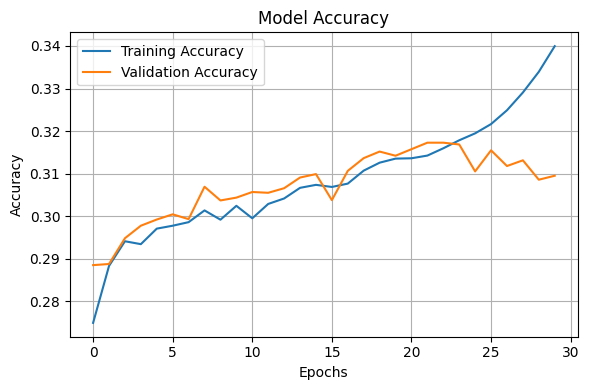

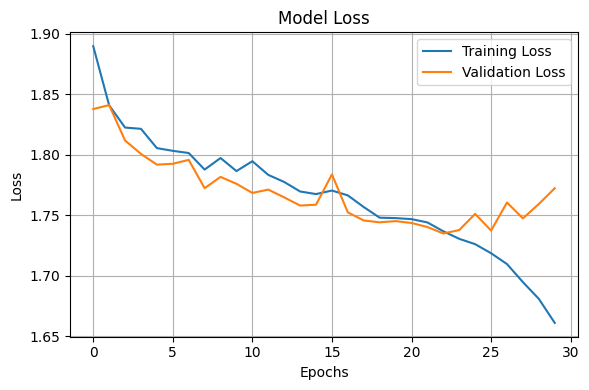

In [21]:
fig_w, fig_h = 6,4
fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Accuracy on the first subplot
axs.plot(tr_acc_all, label='Training Accuracy')
axs.plot(te_acc_all, label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(tr_loss_all, label='Training Loss')
axs.plot(te_loss_all, label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

# Model evaluation

In [ ]:
# To be coded